### The goal of this notebook is to explore modifcations to LAISS.

In [22]:
# Install packages
# !pip install numpy pandas pillow astropy matplotlib scikit-learn
# !pip install astro_ghost
# !pip install timeout_decorator
# !pip install gdown
# !pip install confluent-kafka
# !pip install annoy
# !pip install light-curve
# !pip install antares_client

# Download and unpack data
# !gdown -O ../ 131frC1TmAUenZewuHuY2wuOpXLyUji0m
# !unzip -o ../data.zip -d ../

In [23]:
import os

# a silly hack to switch the working directory to the one where this file is located
working_dir = os.path.abspath("")

import time
import datetime
import math
import numpy as np
import pandas as pd
import sys
import astro_ghost
import os
import subprocess

os.chdir(working_dir)
sys.path.append('../code/')

from helper_functions import *
from laiss_functions import *
from mod_helper_functions import *
from mod_laiss_functions import *

import requests
from requests.auth import HTTPBasicAuth

import warnings
warnings.filterwarnings("ignore")


## Run LAISS

In [24]:
# Set up file structure for the GHOST code that associates transients with their host galaxies.
host_path = "../data/host_info"
if not os.path.exists(host_path):
    os.makedirs(host_path)

os.environ['GHOST_PATH'] = host_path
getGHOST(real=False,verbose=False) # Using dummy host-galaxy association database

GHOST database already exists in the install path!


In [25]:
# Choose LAISS features to use
with open("../data/host_features.txt") as host_f:
    host_features = [line.strip() for line in host_f.readlines()]


with open("../data/lc_features.txt") as lc_f:
    lc_features = [line.strip() for line in lc_f.readlines()]

lc_and_host_features = host_features + lc_features

In [26]:
# Run PCA on light curve and host features to build space of 60 features and build ANNOY index on them
build_indexed_sample(fn='../data/dataset_bank_orig_5472objs.csv.gz', lc_features=lc_features, host_features=host_features, pca=True, save=True)

Loading previously saved ANNOY index


Run main function, `LAISS`. Arguments are:
* `l_or_ztfid_ref`: The ANTARES or ZTF name for the transient to query. By default, the photometry is retrieved as the first step in the pipeline.
* `lc_features`: The light curve features used in the similarity search. 
* `host_features`: The host-galaxy features used in the similarity search.
* `n`: The number of neighbors to retrieve using ANNOY.
* `use_lc_for_ann_only_bool`: Only uses photometry for the similarity search. This could easily be removed!
* `use_ysepz_phot_snana_file`: Instead of retrieving photometry from the ANTARES website, it can be supplied manually in the `timeseries` folder. 
* `show_lightcurves_grid` and `show_hosts_grid`: Shows the neighbors matched to the queried supernova. 
* `run_AD_model`: Additionally runs the random forest classifier to determine an anomaly score of the event at each observation. This requires both light curve and galaxy features to be calculated!
* `savetables`: Saves the intermediate data from the run.
* `savefigs`: Saves the generated figures. 
*  `ad_params`: The parameters of the specific anomaly detection classifier to load (these will always stay the same, unless we re-train the classifier). 

Running LAISS...
ZTF21aaublej is in dataset_bank
ZTF24aahxokj is not in dataset_bank. Checking if made before...
ZTF24aahxokj is already made. Continue!

HOST : http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=336.41637025+8.63830548&filter=color

Loading previously saved ANNOY LC+HOST PCA=60 index
../data/dataset_bank_orig_5472objs_pcaTrue_hostTrue_annoy_index.ann
					   ZTFID IAU_NAME SPEC Z
LC REF: https://alerce.online/object/ZTF21aaublej 2021ixf SN Ia 0.041
HOST REF: https://alerce.online/object/ZTF24aahxokj 2024fca SN II 0.02
ANN=0: https://alerce.online/object/ZTF21aaublej 2021ixf SN Ia, 0.041
ANN=1: https://alerce.online/object/ZTF20abylbuf 2020sme SN Ia, 0.0468
ANN=2: https://alerce.online/object/ZTF20aczgoml 2020adis SN Ia-91T-like, 0.0453189984
ANN=3: https://alerce.online/object/ZTF21aatlesr 2021ipb SN Ia, 0.036912
ANN=4: https://alerce.online/object/ZTF21aaejeyu 2021aip SN Ia, 0.026
ANN=5: https://alerce.online/object/ZTF21abhrmrv 2021qtg SN Ia, 0.04
ANN=6: https://alerc

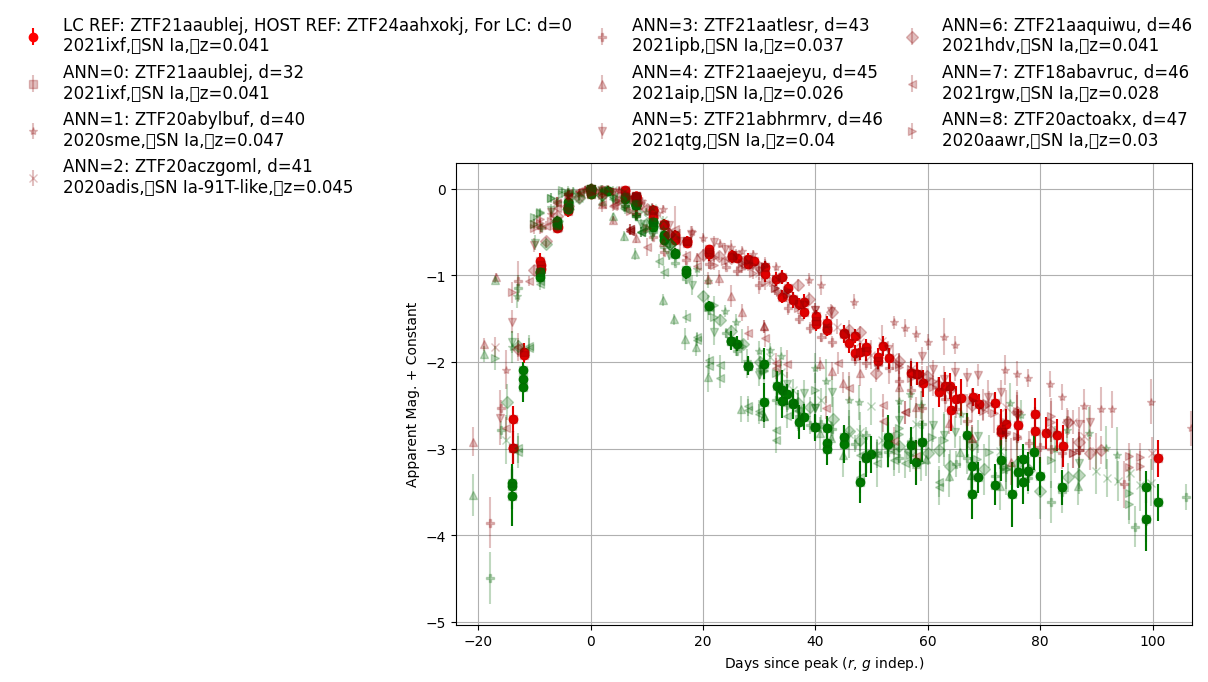


Running AD Model!...
Prediction doesn't exceed anom_threshold of 50% for ZTF21aaublej.
max_anom_score 39.0
num_anom_epochs 0


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


https://alerce.online/object/ZTF21aaublej


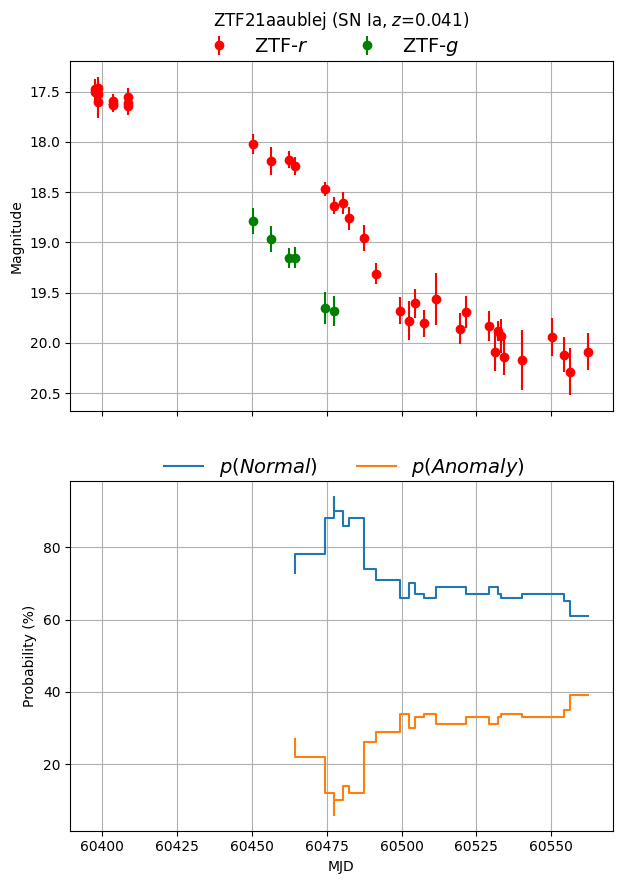

In [27]:
n_estimators = 100
max_depth = 35
random_state = 11
max_features = 35

# LAISS(l_or_ztfid_ref="ZTF21aaublej",  # ZTF21aaublej
#       lc_features=lc_features,
#       host_features=host_features,
#       n=8,
#       use_lc_for_ann_only_bool=False, # currently doesn't work with YSE_snana_format or ANT IDs 
#       use_ysepz_phot_snana_file=False,
#       show_lightcurves_grid=True,
#       show_hosts_grid=False, # host galaxy images currently don't display properly
#       run_AD_model=True, # needs host features for anomaly detection model
#       savetables=False,
#       savefigs=False, 
#      ad_params={'n_estimators':n_estimators, 'max_depth':max_depth, 'random_state':random_state, 'max_features':max_features})

mod_LAISS(LC_l_or_ztfid_ref="ZTF21aaublej",  # ZTF21aaublej
      HOST_l_or_ztfid_ref="ZTF24aahxokj",
      lc_features=lc_features,
      host_features=host_features,
      n=8,
      use_lc_for_ann_only_bool=False, # currently doesn't work with YSE_snana_format or ANT IDs 
      use_ysepz_phot_snana_file=False,
      show_lightcurves_grid=True,
      show_hosts_grid=False, # host galaxy images currently don't display properly
      run_AD_model=True, # needs host features for anomaly detection model, but currently should use host and lc from LC transient
      savetables=False,
      savefigs=False, 
     ad_params={'n_estimators':n_estimators, 'max_depth':max_depth, 'random_state':random_state, 'max_features':max_features})

## Bolometric Luminosity / Magnitude Curve

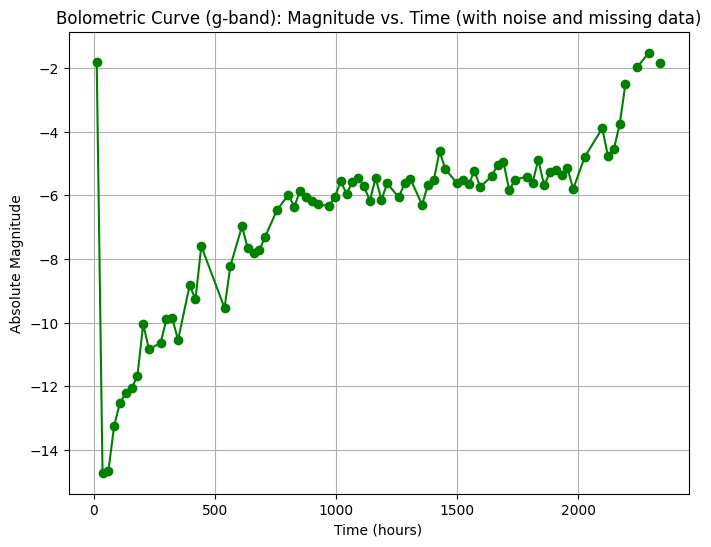

In [28]:
def plot_bolometric_curve(filename, magnitude=False, noise_stddev=0.2, drop_fraction=0.2, band=None):
    data = np.loadtxt(filename, skiprows=1)
    
    # Extract columns for time, wavelength, and luminosity density
    times = data[:, 0]
    wavelengths = data[:, 1]
    llam = data[:, 2]

    # Define the wavelength ranges for ZTF-g and ZTF-r bands
    band_ranges = {
        "g": (3676.00, 5613.82),
        "r": (5497.60, 7394.40)
    }
    
    if band in band_ranges:
        # Filter data for the specified band
        band_min, band_max = band_ranges[band]
        mask = (wavelengths >= band_min) & (wavelengths <= band_max)
        times = times[mask]
        wavelengths = wavelengths[mask]
        llam = llam[mask]

    unique_times = np.unique(times)

    # Sum luminosity density over wavelengths for each time step
    bolometric_luminosity = []
    for time in unique_times:
        total_luminosity = llam[times == time].sum()
        bolometric_luminosity.append(total_luminosity)
    
    # If magnitude=True, convert bolometric luminosity to absolute magnitude
    if magnitude:
        L0 = 3.828e33  # Reference luminosity (erg/s)
        bolometric_magnitude = [-2.5 * np.log10(L / L0) for L in bolometric_luminosity]

        # Add Gaussian noise
        bolometric_magnitude = np.array(bolometric_magnitude)
        noise = np.random.normal(0, noise_stddev, size=bolometric_magnitude.shape)
        bolometric_magnitude += noise

        # Randomly drop some data points
        num_points_to_drop = int(len(bolometric_magnitude) * drop_fraction)
        drop_indices = np.random.choice(len(bolometric_magnitude), num_points_to_drop, replace=False)
        bolometric_magnitude = np.delete(bolometric_magnitude, drop_indices)
        unique_times = np.delete(unique_times, drop_indices)

    # Convert time from seconds to hours
    unique_times = unique_times / 3600.0

    plt.figure(figsize=(8, 6))

    color = 'green' if band == 'g' else 'red' if band == 'r' else 'blue'
    
    if magnitude:
        plt.plot(unique_times, bolometric_magnitude, marker='o', linestyle='-', color=color)
        plt.ylabel('Absolute Magnitude')
        plt.title(f'Bolometric Curve ({band}-band): Magnitude vs. Time (with noise and missing data)')
    else:
        plt.plot(unique_times, bolometric_luminosity, marker='o', linestyle='-', color=color)
        plt.ylabel(f'{band}-band Luminosity (erg/s)')
        plt.title(f'Bolometric Curve ({band}-band): Luminosity vs. Time')

    plt.xlabel('Time (hours)')
    plt.grid(True)
    plt.show()

    if magnitude:
        return np.array(bolometric_magnitude)
    else:
        return np.array(bolometric_luminosity)

bolometric_curve = plot_bolometric_curve("../data/sed_m60.0_mrp5.57_m560.000.dat", magnitude=True, band="g")


## Print LAISS Features

In [29]:
print(f"Number of lc features: {len(lc_features)}")
print(f"LIGHTCURVE FEATURES:")
print("\n".join(lc_features))
print("\n")

print(f"Number of host features: {len(host_features)}")
print(f"HOST FEATURES:")
print("\n".join(host_features))

Number of lc features: 62
LIGHTCURVE FEATURES:
feature_amplitude_magn_r
feature_anderson_darling_normal_magn_r
feature_beyond_1_std_magn_r
feature_beyond_2_std_magn_r
feature_cusum_magn_r
feature_inter_percentile_range_2_magn_r
feature_inter_percentile_range_10_magn_r
feature_inter_percentile_range_25_magn_r
feature_kurtosis_magn_r
feature_linear_fit_slope_magn_r
feature_linear_fit_slope_sigma_magn_r
feature_magnitude_percentage_ratio_40_5_magn_r
feature_magnitude_percentage_ratio_20_5_magn_r
feature_mean_magn_r
feature_median_absolute_deviation_magn_r
feature_percent_amplitude_magn_r
feature_median_buffer_range_percentage_10_magn_r
feature_median_buffer_range_percentage_20_magn_r
feature_percent_difference_magnitude_percentile_5_magn_r
feature_percent_difference_magnitude_percentile_10_magn_r
feature_skew_magn_r
feature_standard_deviation_magn_r
feature_stetson_k_magn_r
feature_weighted_mean_magn_r
feature_anderson_darling_normal_flux_r
feature_cusum_flux_r
feature_excess_variance_flu

## Create LAISS Features for events in provided .csv file

In [31]:
transient_df = pd.read_csv('../data/ZTFBTS.txt')

storage_df = pd.DataFrame()
for idx, ztf_id in enumerate(transient_df['ZTFID']):
    print( f"Processing {ztf_id}, transient number {idx+1} of {len(transient_df['ZTFID'])}" )

    feat_df = mod_extract_lc_and_host_features(
    ztf_id_ref = ztf_id,
    use_lc_for_ann_only_bool = False,
    show_lc=False,
    show_host=False,
    host_features=host_features,
    store_csv=False,
    )

    if feat_df is not None:
        feat_df = feat_df.dropna()
        try:
            lc_and_hosts_df_120d = feat_df[lc_and_host_features]
        except:
            print(f"{ztf_id} has some NaN LC features. Skip!")
            continue

        anom_obj_df = pd.DataFrame(lc_and_hosts_df_120d.iloc[-1]).T
        anom_obj_df['ztf_id'] = ztf_id
        cols = ['ztf_id'] + [col for col in anom_obj_df.columns if col != 'ztf_id']
        anom_obj_df = anom_obj_df[cols]
        anom_obj_df.reset_index(drop=True, inplace=True)

        storage_df = pd.concat([storage_df, anom_obj_df])

    if idx >= 9:
        break

storage_df.to_csv('../data/transient_feature_lib.csv', index=False)

Processing ZTF17aaazdba, transient number 1 of 5860
antares_client can't find this object. Skip! Continue...
Processing ZTF17aabtvsy, transient number 2 of 5860
Extracted LC features for for ZTF17aabtvsy in 1.06s!
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 50.0% of events.
Processing ZTF17aacldgo, transient number 3 of 5860
antares_client can't find this object. Skip! Continue...
Processing ZTF17aadlxmv, transient number 4 of 5860
Extracted LC features for for ZTF17aadlxmv in 1.19s!
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 50.0% of events.
Processing ZTF18aaaibml, transient number 5 of 5860
Extracted LC features for for ZTF18aaaibml in 1.08s!
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 50.0% of events.
Processing ZTF18aaaonon, transient number 6 of 5860
Extracted LC features for for ZTF18aaaonon in 1.52s!
Found no hosts in GLADE.
Finding northern sources 